# Improving subpopulation robustness

In this notebook, we apply Coar attributions to the problem of [subpopulation robustness](https://arxiv.org/abs/1911.08731), where the goal is to maximize model performance on the worst-performing subpopulation. Specifically, we edit a ResNet-50 classifier that is pre-trained on ImageNet and then fine-tuned on Waterbirds and CelebA, two benchmark datasets where standard ERM models latch on to spurious correlations and fare poorly on subpopulations that are underrepresented in the training dataset. This experiment reproduces our findings in Section 5.3 of our paper.

In [2]:
import os 
import sys 
sys.path.append('..')

import functools 
import torch
import numpy as np
import pandas as pd 
from torch import nn
import seaborn as sns
import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

from src.models import cifar_resnet
from src.utils import ndm_utils
from src.utils import data_utils
from src.utils import eval_utils
from src.utils import plot_utils
from src.data import ffcv_pipelines
import coar_edit

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CelebA

#### Download models, attributions, and dataloaders

In [99]:
print ('Downloading dataloaders (FFCV format)')
!wget -nc 'https://www.dropbox.com/scl/fi/pd2x5mtzxokgxhvav5xsz/celeba_test.beton?rlkey=lbm0dxppsszf1qspkduj7b80v&dl=0' -O out/celeba_test.beton
!wget -nc 'https://www.dropbox.com/scl/fi/m29q5wro3t1butp0f6bs4/celeba_val.beton?rlkey=a8v0utdtv7g5a3j0pim5nthhq&dl=0' -O out/celeba_val.beton
!wget -nc 'https://www.dropbox.com/scl/fi/5sqf69lcmxngjs2c1n2os/celeba_train_metadata.pt?rlkey=mc2tgomwlnh7icgojbpywpotc&dl=0' -O out/celeba_train_metadata.pt

print ('Downloading models')
!wget -nc 'https://www.dropbox.com/scl/fi/7z6wqt6bv4hsxmefsbm0i/celeba.pt?rlkey=5jmee0tybtsuffig3ltd76ri7&dl=0' -O out/celeba_model.pt

print ('Downloading attributions')
!wget -nc 'https://www.dropbox.com/s/bfv9xehe6yn6npy/celeba_train.pt?dl=0' -O out/celeba_train_attb.pt 

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/celeba_test.beton’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/celeba_val.beton’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/celeba_train_metadata.pt’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/celeba_model.pt’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/celeba_train_attb.pt’ already there; not retrieving.


#### Setup

In [100]:
DEVICE = torch.device(0) 

def get_model():
    return torch.load('out/celeba_model.pt').cpu().eval()

def get_attributions():
    pth = 'out/celeba_train_attb.pt'
    return torch.load(pth)['weight'].T.float()

def get_loaders(batch_size=256, num_workers=2):
    pipeline = ffcv_pipelines.get_pipelines('celeba', 'test', DEVICE)

    loaders = { 
        'val': 'out/celeba_val.beton', 
        'test': 'out/celeba_test.beton' 
    }
    
    return {k: data_utils.get_ffcv_loader(v, batch_size, num_workers, pipeline, is_train=False)
            for k, v in loaders.items()}

# get model, data, attributions 
model = get_model()
comps = coar_edit.get_resnet50_components(model)
num_components = sum(comps.values())

loader_map = get_loaders() 
attb = get_attributions()
editor = coar_edit.CoarEdit()

num_components

22720

In [101]:
# eval subpop-wise accs 
label_names_map = {
    (1,1): 'Blonde male',
    (0,0): 'Non-blonde female',
    (1,0): 'Blonde female',
    (0,1): 'Non-blonde male'
}

model = model.to(DEVICE)
group_accs = eval_utils.get_groupwise_accuracy(model, loader_map['test'], DEVICE)

for g, acc in group_accs.items():
    print ('{}: {:.2f}'.format(label_names_map[g], acc))

Non-blonde female: 0.95
Non-blonde male: 0.99
Blonde female: 0.89
Blonde male: 0.47


#### Apply Coar-Edit

In [102]:
# get metadata 
train_metadata = torch.load('out/celeba_train_metadata.pt')
labels = train_metadata['labels']
groups = train_metadata['groups']
subpops = list(zip(labels, groups))

subpops_map = defaultdict(list)
for idx, subpop in enumerate(subpops):
    subpops_map[subpop].append(idx)

In [120]:
# prepare inputs 
num_samples = 20 # number of examples per subpop

sample_inds = {g: np.random.choice(v, size=num_samples, replace=False) for g, v in subpops_map.items()}
sampled_attb_map = {g: attb[inds] for g, inds in sample_inds.items()}

target_examples = sampled_attb_map[(1,1)] # sample from blonde males subpop
# ref_examples = attb[np.random.choice(attb.shape[0], size=num_samples*4, replace=False)]
ref_examples = torch.concatenate([v for k, v in sampled_attb_map.items() if k!=(1,1)])

print ('target examples', target_examples.shape)
print ('reference examples', ref_examples.shape)

target examples torch.Size([20, 22720])
reference examples torch.Size([60, 22720])


In [121]:
# use Coar-Edit to identify a subset of components to ablate 
subset_size = 35 # number of components to ablate 
ablate_order = 'bottomk' # get components with most negative scores (to increase margin)

scores = editor.score_components(target_examples, ref_examples)
subset = editor.get_subset(scores, subset_size, ablate_order)
subset_inds = subset.indices.numpy()
ablate_set = [ndm_utils.get_component_from_index(ind, comps) for ind in subset_inds]
ablate_set[:10]

[('layer4.2.conv3.weight', 329),
 ('layer4.2.conv3.weight', 1800),
 ('layer4.0.conv3.weight', 729),
 ('layer4.1.conv2.weight', 384),
 ('layer4.1.conv2.weight', 188),
 ('layer4.1.conv2.weight', 26),
 ('layer4.1.conv1.weight', 234),
 ('layer4.1.conv2.weight', 364),
 ('layer4.1.conv2.weight', 112),
 ('layer4.1.conv1.weight', 229)]

In [122]:
# iteratively ablate identified components and evaluate model performance 
masked_model = get_model()

eval_loaders = {
    'test': loader_map['test'], 
    'val': loader_map['val']
}

eval_every = 3
rows = [] 

for k, (comp_name, comp_idx) in (pbar:=tqdm.tqdm(list(enumerate(ablate_set)))):
    # ablate
    masked_model = editor.ablate_model_given_component(masked_model, comp_name, comp_idx)
    masked_model = masked_model.to(DEVICE)
    if k % eval_every != 0: 
        continue 
    
    # eval + log
    row = {} 
    for split, dl in eval_loaders.items():
        accs = eval_utils.get_groupwise_accuracy(masked_model, dl, DEVICE)
        row[split] = min(accs.values())
        
    row['Num. components ablated'] = k
    rows.append(row)
    pbar.set_description('(val:{:.2f}, test:{:.2f})'.format(row['val'], row['test']))

df = pd.DataFrame(rows)

(val:0.79, test:0.82): 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [01:26<00:00,  2.47s/it]


,test,val,Num. components ablated
8,0.85,0.81,24
10,0.85,0.81,30
9,0.84,0.81,27
11,0.82,0.79,33
7,0.82,0.79,21


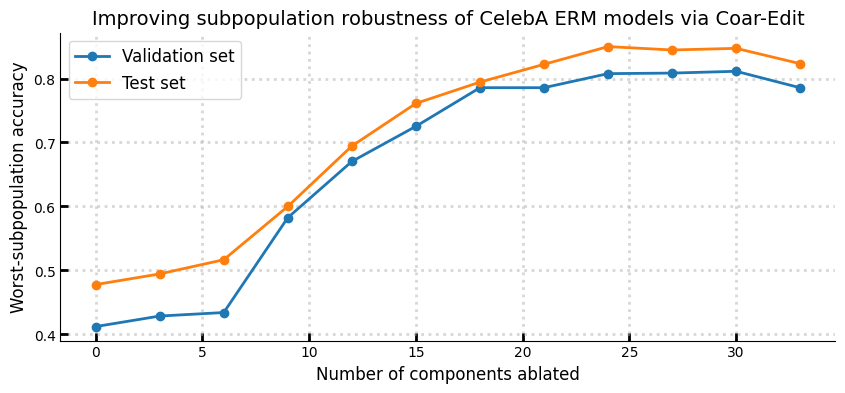

In [124]:
# plot results 
fig, ax = plt.subplots(1,1,figsize=(10,4))
x = df['Num. components ablated']
ax.plot(x, df['val'], label='Validation set', marker='o', lw=2)
ax.plot(x, df['test'], label='Test set', marker='o', lw=2)
plot_utils.update_ax(ax, 'Improving subpopulation robustness of CelebA ERM models via Coar-Edit', 
                     'Number of components ablated', 'Worst-subpopulation accuracy')

df.sort_values('test', ascending=False).round(2).head()

## Waterbirds

#### Download models, attributions, and dataloaders

In [83]:
print ('Downloading dataloaders (FFCV format)')
!wget -nc 'https://www.dropbox.com/scl/fi/hhwhbh76oswpwtz3r5enp/waterbirds_train.beton?rlkey=l67468mgijmsqdrrep5rcsz75&dl=0' -O out/waterbirds_train.beton
!wget -nc 'https://www.dropbox.com/scl/fi/aqaoyi6uh0zhsta45u7be/waterbirds_test.beton?rlkey=u2sq41jrxwa74zxzomkt2m6wb&dl=0' -O out/waterbirds_test.beton 
!wget -nc 'https://www.dropbox.com/scl/fi/xpwvyripqj1bwz5iskv3j/waterbirds_val.beton?rlkey=15xq9tysvn3lfhvgx8m52snn2&dl=0' -O out/waterbirds_val.beton

print ('Downloading models')
!wget -nc 'https://www.dropbox.com/scl/fi/1s3tkijob7xqyytv9go9k/waterbirds.pt?rlkey=tjor5safav9f1u73yktcdz4u5&dl=0' -O out/waterbirds_model.pt

print ('Downloading attributions')
!wget -nc 'https://www.dropbox.com/scl/fi/dqt5kewb282all574wgae/waterbirds_train.pt?rlkey=83rw1g5afyj3adh48d5mnsnpi&dl=0' -O out/waterbirds_train_attb.pt 

Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/waterbirds_train.beton’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/waterbirds_test.beton’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/waterbirds_val.beton’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/waterbirds_model.pt’ already there; not retrieving.
Unable to join threads to shut down before fork(). This can break multithreading in child processes.

File ‘out/waterbirds_train_attb.pt’ already there; not retrieving.


#### Setup

In [84]:
DEVICE = torch.device(0) 

def get_model():
    model = torch.load('out/waterbirds_model.pt').cpu().eval()
    return model

def get_attributions():
    pth = 'out/waterbirds_train_attb.pt'
    return torch.load(pth)['weight'].T.float()

def get_loaders(batch_size=256, num_workers=2):
    pipeline = ffcv_pipelines.get_pipelines('waterbirds', 'test', DEVICE)

    loaders = { 
        'train': 'out/waterbirds_train.beton', 
        'val': 'out/waterbirds_val.beton', 
        'test': 'out/waterbirds_test.beton' 
    }
    
    return {k: data_utils.get_ffcv_loader(v, batch_size, num_workers, pipeline, is_train=False)
            for k, v in loaders.items()}

In [85]:
# get model, data, attributions 
model = get_model()
comps = coar_edit.get_resnet50_components(model)
num_components = sum(comps.values())

loader_map = get_loaders() 
attb = get_attributions()
editor = coar_edit.CoarEdit()

num_components

22720

In [86]:
# eval subpop-wise accs 
label_names_map = {
    (1,1): 'waterbirds + water background',
    (0,0): 'landbirds + land background',
    (1,0): 'waterbirds + land background',
    (0,1): 'landbirds + water background'
}

model = model.to(DEVICE)
group_accs = eval_utils.get_groupwise_accuracy(model, loader_map['test'], DEVICE)

for g, acc in group_accs.items():
    print ('{}: {:.2f}'.format(label_names_map[g], acc))

waterbirds + water background: 0.95
waterbirds + land background: 0.64
landbirds + land background: 1.00
landbirds + water background: 0.83


#### Apply Coar-Edit

In [87]:
# get metadata 
labels = eval_utils.get_labels(loader_map['train'], label_index=1)
groups = eval_utils.get_labels(loader_map['train'], label_index=2)
subpops = list(zip(labels, groups))

subpops_map = defaultdict(list)
for idx, subpop in enumerate(subpops):
    subpops_map[subpop].append(idx)

Exception ignored in: <finalize object at 0x7f3de3fa9800; dead>
Traceback (most recent call last):
  File "/mnt/xfs/home/harshay/conda_envs/hs_xfs/lib/python3.10/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/mnt/xfs/home/harshay/conda_envs/hs_xfs/lib/python3.10/site-packages/numba/core/dispatcher.py", line 312, in finalizer
    for cres in overloads.values():
KeyError: (array(uint8, 1d, C), array(uint8, 1d, C), uint32, uint32, uint32, uint32, Literal[int](0), Literal[int](0), Literal[int](1), Literal[int](1), Literal[bool](False), Literal[bool](False), Literal[bool](True))


In [92]:
# prepare inputs 
num_samples = 10 # number of examples per subpop

sample_inds = {g: np.random.choice(v, size=num_samples, replace=False) for g, v in subpops_map.items()}
sampled_attb_map = {g: attb[inds] for g, inds in sample_inds.items()}

target_examples = torch.concat([sampled_attb_map[(1,0)], sampled_attb_map[(0,1)]]) # minority groups
ref_examples = attb[np.random.choice(attb.shape[0], size=num_samples*4, replace=False)]

print ('target examples', target_examples.shape)
print ('reference examples', ref_examples.shape)

target examples torch.Size([20, 22720])
reference examples torch.Size([40, 22720])


In [96]:
# use Coar-Edit to identify a subset of components to ablate 
subset_size = 330 # number of components to ablate 
ablate_order = 'bottomk' # get components with most negative scores (to increase margin)

scores = editor.score_components(target_examples, ref_examples)
subset = editor.get_subset(scores, subset_size, ablate_order)
subset_inds = subset.indices.numpy()
ablate_set = [ndm_utils.get_component_from_index(ind, comps) for ind in subset_inds]
ablate_set[:10]

[('base_model.layer4.1.conv2.weight', 200),
 ('base_model.layer3.5.conv3.weight', 157),
 ('base_model.layer3.2.conv3.weight', 437),
 ('base_model.layer4.1.conv2.weight', 418),
 ('base_model.layer3.1.conv3.weight', 437),
 ('base_model.layer4.0.conv3.weight', 1362),
 ('base_model.layer3.1.conv3.weight', 157),
 ('base_model.layer3.0.conv3.weight', 948),
 ('base_model.layer4.1.conv3.weight', 239),
 ('base_model.layer4.0.conv3.weight', 729)]

In [97]:
# iteratively ablate identified components and evaluate model performance 
masked_model = get_model()

eval_loaders = {
    'test': loader_map['test'], 
    'val': loader_map['val']
}

eval_every = 10
rows = [] 

for k, (comp_name, comp_idx) in (pbar:=tqdm.tqdm(list(enumerate(ablate_set)))):
    # ablate
    masked_model = editor.ablate_model_given_component(masked_model, comp_name, comp_idx)
    masked_model = masked_model.to(DEVICE)
    if k % eval_every != 0: 
        continue 
    
    # eval + log
    row = {} 
    for split, dl in eval_loaders.items():
        accs = eval_utils.get_groupwise_accuracy(masked_model, dl, DEVICE)
        row[split] = min(accs.values())
        
    row['Num. components ablated'] = k
    rows.append(row)
    pbar.set_description('(val:{:.2f}, test:{:.2f})'.format(row['val'], row['test']))

df = pd.DataFrame(rows)

(val:0.83, test:0.81): 100%|████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [02:20<00:00,  2.35it/s]


,test,val,Num. components ablated
28,0.83,0.84,280
27,0.83,0.84,270
29,0.83,0.84,290
30,0.82,0.84,300
31,0.82,0.83,310


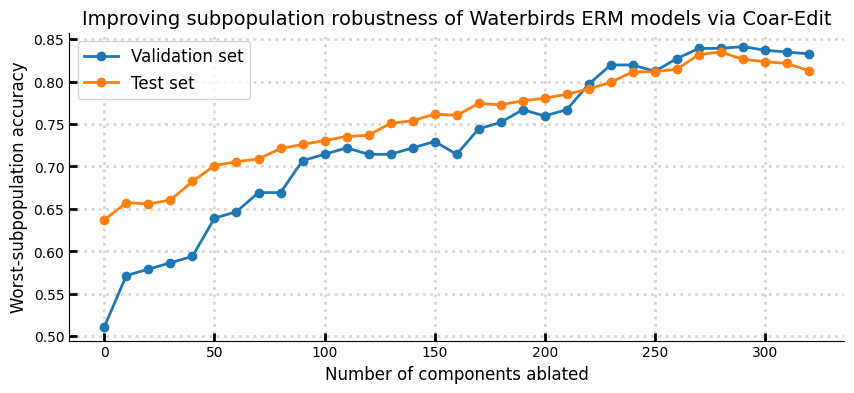

In [103]:
# plot results 
fig, ax = plt.subplots(1,1,figsize=(10,4))
x = df['Num. components ablated']
ax.plot(x, df['val'], label='Validation set', marker='o', lw=2)
ax.plot(x, df['test'], label='Test set', marker='o', lw=2)
plot_utils.update_ax(ax, 'Improving subpopulation robustness of Waterbirds ERM models via Coar-Edit', 
                     'Number of components ablated', 'Worst-subpopulation accuracy')

df.sort_values('test', ascending=False).round(2).head()